In [1]:
# fixar figuras no conteudo do notebook
%matplotlib inline
# atualizar pacote
#!pip install --upgrade scikit-learn
# pacotes básicos
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pacotes do sklearn para acesso a datasets, preparação, modelagem e avaliação
from sklearn import datasets
#
# pacote para separação entre treino e teste
from sklearn.model_selection import train_test_split
#
# arsenal de preparação
from sklearn.preprocessing import MinMaxScaler # rescala em min-max
from sklearn.preprocessing import StandardScaler # padroniza features removendo média e
#     escalando para variância unitária. Também chamado de z-score
#
# pacote pipeline para combinar preparação e modelagem
from sklearn.pipeline import Pipeline, make_pipeline
#
# pacotes para validação cruzada
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
#
# pacotes de indução de modelos
from sklearn.tree import DecisionTreeClassifier
#
# pacotes para avaliação dos resultados
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import plot_tree, export_graphviz, export_text

#pacotes para apoio a leitura e gravação de datasets
from pathlib import Path
import csv

#pacotes para visualização e formatação
import pprint
import graphviz
#
# configurações para os diferentes pacotes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# carga de dados
breast_cancer = datasets.load_breast_cancer(as_frame=True)
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [3]:
# separação em features e target
X = breast_cancer.data
y = breast_cancer.target
breast_cancer.frame.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.256,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.595,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.3857,1.428,2.548,19.15,0.007189,0.00466,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [4]:
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [5]:
# separação em treino e teste, e X e y

treino_X, teste_X, treino_y, teste_y = train_test_split(X, y, random_state=0,test_size=0.2, stratify=y)

print(treino_X.shape)
print(treino_y.shape)
print(teste_X.shape)
print(teste_y.shape)
print(np.stack(np.unique(teste_y, return_counts=True), axis=1))

(455, 30)
(455,)
(114, 30)
(114,)
[[ 0 42]
 [ 1 72]]


In [6]:
# indução do modelo para diferentes valores para os parâmetros, com validação cruzada

#ccp_alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 1.0, 10.0, 100.0]
ccp_alphas = [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.055, 0.06, 0.07, 0.08, 0.09, 0.1]
#              0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
#ccp_alphas = [0.055]
#ccp_alphas = [0.0]
max_leafs = [2, 3, 4, 5, 6, 7, 8, 9]#, 10, 11, 13, 15, 17, 21]

k_splits = 10

modelo = Pipeline(steps=[('reescala', MinMaxScaler()),
    ('modelo', DecisionTreeClassifier(random_state=0))])

parametros = {'reescala__feature_range':[(0,1)],
              'modelo__ccp_alpha': ccp_alphas,
              'modelo__max_leaf_nodes':max_leafs,
              'modelo__criterion':['gini','entropy']}

skfold = StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=0)

valcruz = GridSearchCV(modelo, parametros,cv=skfold)

valcruz.fit(treino_X, treino_y)

resultados = pd.DataFrame(valcruz.cv_results_).sort_values(by='rank_test_score')
melhor_feature_range = resultados['param_reescala__feature_range'].iloc[0]
melhor_criterion = resultados['param_modelo__criterion'].iloc[0]
melhor_max_leaf_nodes = resultados['param_modelo__max_leaf_nodes'].iloc[0]
melhor_ccp_alpha = resultados['param_modelo__ccp_alpha'].iloc[0]

resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modelo__ccp_alpha,param_modelo__criterion,param_modelo__max_leaf_nodes,param_reescala__feature_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
78,0.005182,0.000558,0.001211,0.000981,0.020,entropy,8,"(0, 1)","{'modelo__ccp_alpha': 0.02, 'modelo__criterion...",1.0,0.956522,0.934783,0.891304,0.913043,0.911111,0.888889,0.955556,0.955556,0.977778,0.938454,0.035117,1
15,0.010099,0.000702,0.002056,0.000564,0.000,entropy,9,"(0, 1)","{'modelo__ccp_alpha': 0.0, 'modelo__criterion'...",1.0,0.956522,0.913043,0.891304,0.913043,0.911111,0.888889,0.977778,0.955556,0.955556,0.936280,0.035941,2
63,0.010849,0.002673,0.002007,0.000631,0.015,entropy,9,"(0, 1)","{'modelo__ccp_alpha': 0.015, 'modelo__criterio...",1.0,0.956522,0.913043,0.891304,0.913043,0.911111,0.888889,0.977778,0.955556,0.955556,0.936280,0.035941,2
31,0.006548,0.002612,0.000903,0.000301,0.005,entropy,9,"(0, 1)","{'modelo__ccp_alpha': 0.005, 'modelo__criterio...",1.0,0.956522,0.913043,0.891304,0.913043,0.911111,0.888889,0.977778,0.955556,0.955556,0.936280,0.035941,2
47,0.005320,0.000644,0.000582,0.000476,0.010,entropy,9,"(0, 1)","{'modelo__ccp_alpha': 0.01, 'modelo__criterion...",1.0,0.956522,0.913043,0.891304,0.913043,0.911111,0.888889,0.977778,0.955556,0.955556,0.936280,0.035941,2


In [7]:
# listar os melhores resultados para os parâmetros

print('Melhor preparação - Feature Range:{}'.format(melhor_feature_range))
print('Melhor resultado - Critério:{}   Máximo número de nodos folha:{}   Alfa:{}    Acurácia média:{:.3f}'.format(
    melhor_criterion,
    melhor_max_leaf_nodes,
    melhor_ccp_alpha,
    resultados['mean_test_score'].iloc[0]))


Melhor preparação - Feature Range:(0, 1)
Melhor resultado - Critério:entropy   Máximo número de nodos folha:8   Alfa:0.02    Acurácia média:0.938


## Execução para os melhores parâmetros

Acuracia=0.930


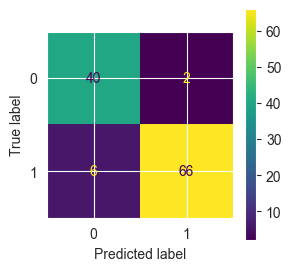

In [8]:
escalonador = MinMaxScaler(feature_range = melhor_feature_range)
estimador = DecisionTreeClassifier(ccp_alpha = melhor_ccp_alpha,
                                   max_leaf_nodes = melhor_max_leaf_nodes,
                                   criterion = melhor_criterion)
treino_X_escalonado = escalonador.fit_transform(treino_X, treino_y)
estimador.fit(treino_X_escalonado, treino_y)
teste_X_escalonado = escalonador.transform(teste_X)
teste_pred_y = estimador.predict(teste_X_escalonado)
acuracia = accuracy_score(teste_y, teste_pred_y)
resultado = confusion_matrix(teste_y, teste_pred_y)
cm_display = ConfusionMatrixDisplay(resultado).plot()
fig = cm_display.figure_
fig.set_figheight(3)
fig.set_figwidth(3)
print('Acuracia={:.3f}'.format(acuracia))

In [9]:
# apresentações do modelo
modelo_txt = export_text(estimador, feature_names=list(breast_cancer.feature_names))
print(modelo_txt)

|--- worst perimeter <= 0.26
|   |--- worst concave points <= 0.46
|   |   |--- area error <= 0.08
|   |   |   |--- class: 1
|   |   |--- area error >  0.08
|   |   |   |--- class: 0
|   |--- worst concave points >  0.46
|   |   |--- worst texture <= 0.37
|   |   |   |--- class: 1
|   |   |--- worst texture >  0.37
|   |   |   |--- class: 0
|--- worst perimeter >  0.26
|   |--- worst concave points <= 0.50
|   |   |--- worst texture <= 0.21
|   |   |   |--- class: 1
|   |   |--- worst texture >  0.21
|   |   |   |--- worst radius <= 0.30
|   |   |   |   |--- class: 1
|   |   |   |--- worst radius >  0.30
|   |   |   |   |--- class: 0
|   |--- worst concave points >  0.50
|   |   |--- class: 0



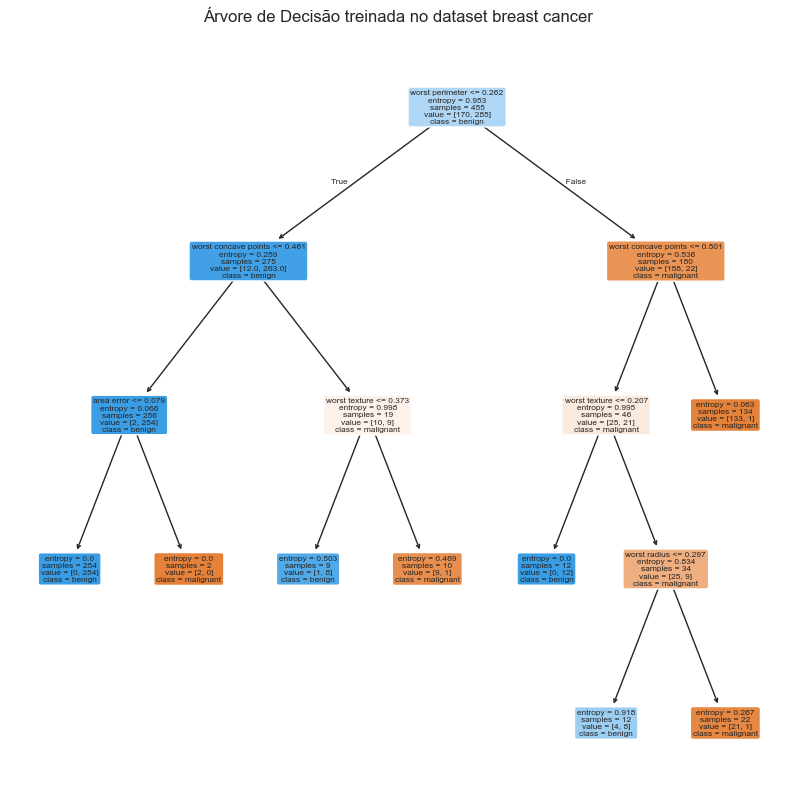

In [10]:
# apresentações do modelo
plt.figure(figsize=(10, 10))
plot_tree(estimador, filled=True, rounded=True,
          feature_names=list(breast_cancer.feature_names),
          class_names=list(breast_cancer.target_names))
plt.title('Árvore de Decisão treinada no dataset breast cancer')
plt.show()

### Curva ROC com AUC

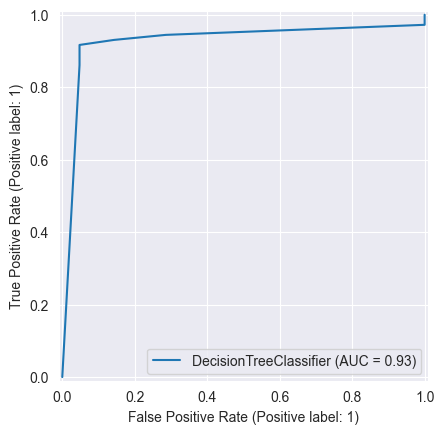

In [11]:
RocCurveDisplay.from_estimator(estimador, teste_X_escalonado, teste_y)

## Mostra da distribuição de pontos e classes

In [12]:
treino_X_escalonado_DF = pd.DataFrame(treino_X_escalonado, columns=list(breast_cancer.feature_names))
X_mostra = treino_X_escalonado_DF[['worst perimeter', 'worst concave points']].copy()

teste_X_escalonado_DF = pd.DataFrame(teste_X_escalonado, columns=list(breast_cancer.feature_names))
X_teste_mostra = teste_X_escalonado_DF[['worst perimeter', 'worst concave points']].copy()


In [13]:
modelo_mostra = DecisionTreeClassifier(ccp_alpha = melhor_ccp_alpha,
                                   max_leaf_nodes = melhor_max_leaf_nodes,
                                   criterion = melhor_criterion)

modelo_mostra.fit(X_mostra, treino_y)

DecisionTreeClassifier(ccp_alpha=np.float64(0.02), criterion='entropy',
                       max_leaf_nodes=np.int64(8))

### Fundo e pontos a partir do treino

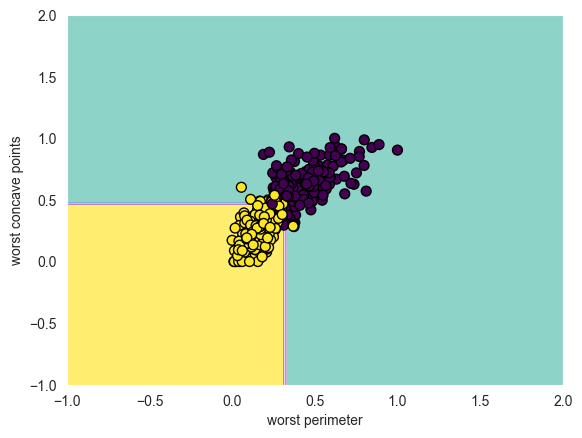

In [14]:

mostra = DecisionBoundaryDisplay.from_estimator(
    modelo_mostra,
    X_mostra,
    response_method="predict",
    cmap=plt.cm.Set3,
    xlabel='worst perimeter',
    ylabel='worst concave points',
)
mostra.ax_.scatter(
    X_mostra['worst perimeter'], X_mostra['worst concave points'], c=treino_y, s=50,
    cmap=plt.cm.viridis, edgecolor="black", linewidth=1
)

### Fundo a partir do treino e pontos a partir do teste

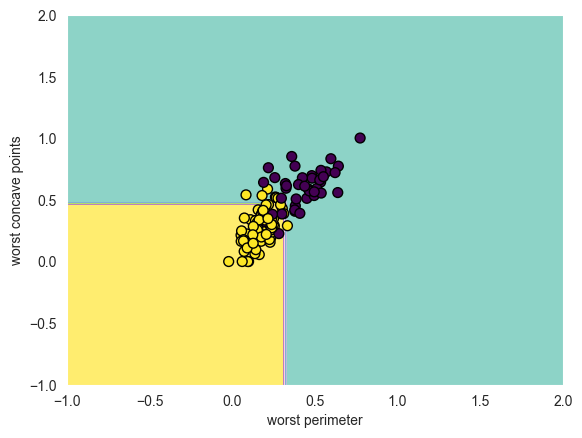

In [15]:

mostra = DecisionBoundaryDisplay.from_estimator(
    modelo_mostra,
    X_mostra,
    response_method="predict",
    cmap=plt.cm.Set3,
    xlabel='worst perimeter',
    ylabel='worst concave points',
)
mostra.ax_.scatter(
    X_teste_mostra['worst perimeter'], X_teste_mostra['worst concave points'], c=teste_y, s=50,
    cmap=plt.cm.viridis, edgecolor="black", linewidth=1
)